In [1]:
import sqlite3
import os
from pathlib import Path as pth
import subprocess as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
import seaborn  as sns
import re
import unicodedata
from typing import List, Tuple, Any

## Change working directory

In [2]:
os.chdir(pth(pth.home() / 'dev/sms-analysis'))

## Load Data

In [3]:
messages = pd.read_csv('processed-data/X-messages.csv')
messages.head()

,date_time,text,from_me,sender
0,2021-03-11 17:25:57,So when is a good time?,1,13608307613
1,2021-03-11 17:26:37,Tuesday’s I’m free after 1130,1,13608307613
2,2021-03-11 23:51:13,this is Christian right?,0,13608307613
3,2021-03-11 23:52:07,im done at 3 on tuesday’s so anytime after tha...,0,13608307613
4,2021-03-12 09:17:13,Sounds like a plan,1,13608307613


## flag where they respond to me and where i respond to them

In [4]:
# flag their response 
messages = (
    messages
    .assign( their_response= lambda df: 
            (df["from_me"] == 0) & (df.from_me.shift(1)  == 1) # their response is when last is 1 and current 0 (shift(1) = lag(1))
        )
    .assign( my_response= lambda df: 
        (df["from_me"] == 1) & (df.from_me.shift(1)  == 0) # current me, previous them
    )
)

messages.head()

,date_time,text,from_me,sender,their_response,my_response
0,2021-03-11 17:25:57,So when is a good time?,1,13608307613,False,False
1,2021-03-11 17:26:37,Tuesday’s I’m free after 1130,1,13608307613,False,False
2,2021-03-11 23:51:13,this is Christian right?,0,13608307613,True,False
3,2021-03-11 23:52:07,im done at 3 on tuesday’s so anytime after tha...,0,13608307613,False,False
4,2021-03-12 09:17:13,Sounds like a plan,1,13608307613,False,True


## Calculate response time

In [5]:
messages['date_time'] = pd.to_datetime(messages.date_time)

messages = (
    messages 
    .assign(time_diff = lambda df: df.date_time.diff() )
    .assign(time_diff_sec = lambda df: (df.time_diff.dt.total_seconds().round().astype('Int64') ))
)

## Analyze response times

Their median response time = 5 minutes
My median response time = 9 minutes
Their mean response time = 119 minutes
My mean response time = 145 minutes


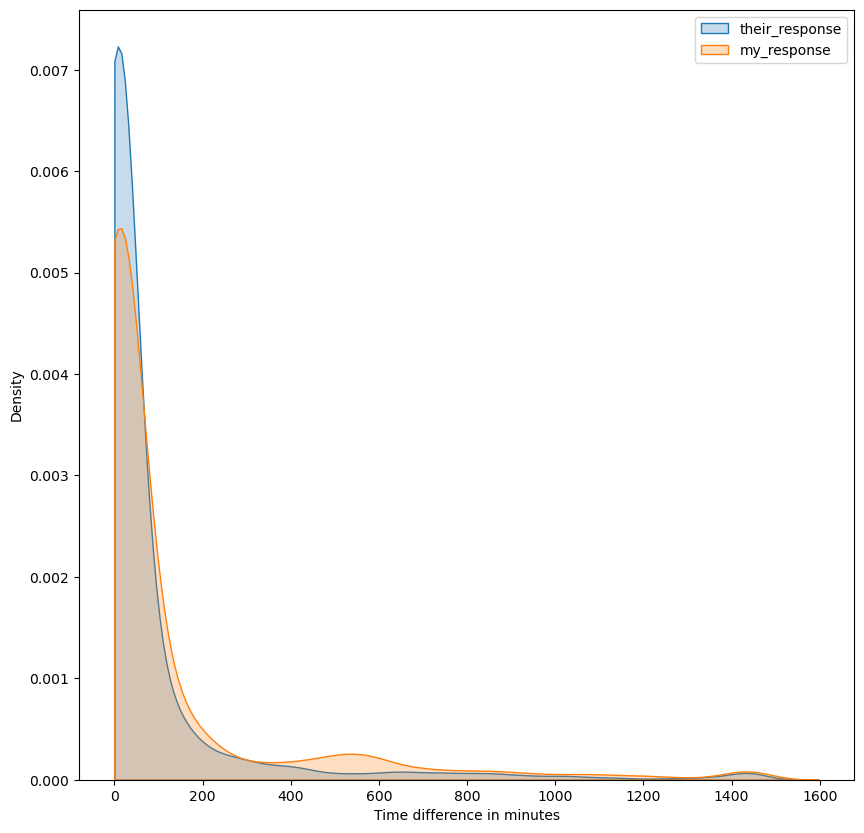

In [6]:
print("Their median response time =",  round(np.median(messages['time_diff_sec'][messages['their_response']])/60), "minutes")
print("My median response time =",  round(np.median(messages['time_diff_sec'][messages['my_response']])/60), "minutes")

print("Their mean response time =",  round(np.mean(messages['time_diff_sec'][messages['their_response']])/60), "minutes")
print("My mean response time =",  round(np.mean(messages['time_diff_sec'][messages['my_response']])/60), "minutes")

#       min->hour->day->days
upper = 60*60*24*1
their_time = (
    messages.loc[messages["their_response"], "time_diff_sec"]
    .clip(lower=1, upper = upper)
    .dropna()
)

my_time = (
    messages.loc[messages["my_response"], "time_diff_sec"]
    .clip(lower=1, upper = upper)
    .dropna()
)

# plt.boxplot([np.log(their_time/60),np.log(my_time/60)], tick_labels=["their_response", "my_response"])
# plt.ylabel("ln(Time difference in minutes)")
# plt.show()

plt.figure(figsize=(10, 10))
sns.kdeplot(their_time/60, label="their_response", fill=True, clip = (0,None))
sns.kdeplot(my_time/60, label="my_response", fill=True, clip = (0,None))

plt.xlabel("Time difference in minutes")
plt.ylabel("Density")
plt.legend()
plt.show()

Hump around 500 minutes probably because they text late and i don't respond till i wake up, around 8 hours later.